We do a bit more EDA, now that we cleaned up the features a bit.

In [77]:
# functions for loading and cleaning
def load_data_from_two(path_to_data,path_to_cols):
    """
    loads data and returns a pandas dataframe
    requires: import pandas as pd
    """
    col_names = []
    with open('census-income.columns', 'r') as f:
        for line in f.readlines():
            col_names.append(line[:-1])

    df = pd.read_csv('census-income.data', names=col_names)
    return df

def fill_nan_hisp(data):
    """
    assumes data is a pandas dataframe
    modifies data in place
    """
    assert 'hispanic origin' in data.columns, "Hispanic column missing"
    data['hispanic origin'].fillna(value='All other', inplace=True)
    return None

def encode_cols(data):
    """
    ad hoc function to create 0/1 column for label
    """
    from sklearn.preprocessing import LabelEncoder
    data['label_encoded'] = LabelEncoder().fit_transform(data['label'])
    data['sex_encoded'] = LabelEncoder().fit_transform(data['sex'])
    data['year_encoded'] = LabelEncoder().fit_transform(data['year'])
    return None

def bucket_features(data):
    """
    assumes data is a pandas dataframe containing data types object, float, and int.
    returns two sets of column names, according to type float or other
    """
    numerical_types = ['int64', 'float64']
    var_cont = set()
    var_disc = set()
    for col in data.columns:
        if data.dtypes[col] in numerical_types:
            var_cont.add(col)
        else:
            var_disc.add(col)
            
    var_cont.remove('label_encoded')
    var_cont.remove('instance weight')

    to_swap=['veterans benefits',
            'own business or self employed',
            'sex_encoded',
            'year_encoded']

    for col_name in to_swap:
        var_cont.remove(col_name)
        var_disc.add(col_name)

    return (var_cont,var_disc)

def clean_country(data):
    def helper(country):
        if country == 'United-States' or country == "Mexico":
            return country
        else:
            return 'Other'
    
    data['country'] = data['country of birth mother'].apply(helper)
    return None
        

def load_for_training(path_to_data,path_to_columns,make_dummies=False):
    # load data from files
    df = load_data_from_two('census-income.data', 'census-income.columns')

    # fill nans from hispanic column
    fill_nan_hisp(df)
    # encode sex and label columns
    encode_cols(df)
    
    # clean country
    clean_country(df)

#     # split outputs and weights from data
#     y = df['label_encoded']
#     w = df['instance weight']
    
    # drop labels we don't use anymore
    # note: label_encoded and instance_weight are still in df
    df = df.drop(columns=['label', 'sex', 'year'])

    # drop correlated features
    to_drop = ['migration code-change in msa',
                'detailed industry recode',
                'detailed occupation recode',
                'migration code-move within reg',
                'live in this house 1 year ago',
                "fill inc questionnaire for veteran's admin",
                'migration code-change in reg',
                'migration prev res in sunbelt',
                'major industry code',
                'state of previous residence',
                'detailed household and family stat',
                'country of birth self',
                'country of birth father',
                'country of birth mother',
                'citizenship']

    df = df.drop(columns=to_drop)

    # group features by type
    var_cont,var_disc = bucket_features(df)

    if make_dummies:
        df = pd.get_dummies(df, columns=var_disc)

    return (df,var_cont,var_disc)

def get_sorted_feats_by_corr(data):
    """
    data is pandas dataframe
    returns corr_vals sorted by abs value
    """
    cols = data.columns
    dupes_to_drop = { (data.columns[i],data.columns[j]) for i in range(data.shape[1]) for j in range(i+1) }
    
    return data.corr().abs().unstack().drop(labels=dupes_to_drop).sort_values(ascending=False)

In [78]:
import pandas as pd
df,var_cont,var_disc = load_for_training('census-income.data','census-income.columns',make_dummies=False)

In [79]:
# functions for plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

# to plot NORMALIZED histograms
# (density=True)
def plot_cont(df,var_cont,use_log=True,fig_size_x=12,fig_size_y=60, save_path=None):

    class_0 = df[df['label_encoded'] == 0]
    class_1 = df[df['label_encoded'] == 1]

    numerical_features = sorted(list(var_cont))
    n = len(numerical_features)

    fig, axes = plt.subplots(n,1,figsize=(fig_size_x,fig_size_y))
    ax = axes.ravel()
    for i in range(n):
        ax[i].hist(class_0[numerical_features[i]],bins=30,density=False)
        ax[i].hist(class_1[numerical_features[i]],bins=30,density=False)
        ax[i].set_title(numerical_features[i])
        if use_log:
            ax[i].set_yscale('log')
        sns.despine()
    ax[0].legend(['less than 50k', 'more than 50k'])
    if save_path:
        pass
        # save fig
    return None

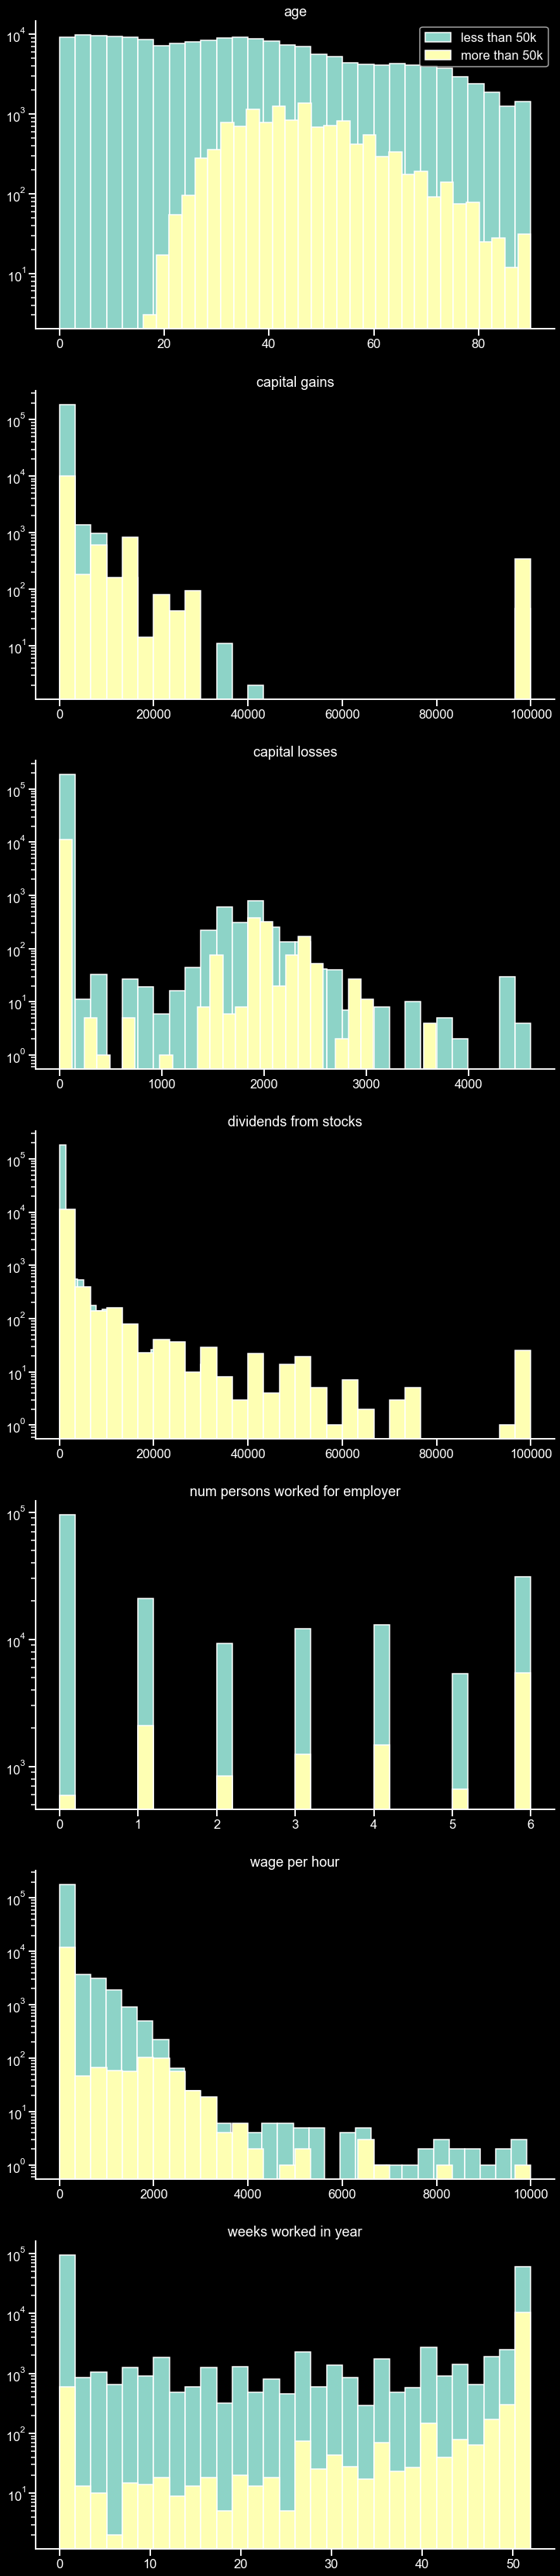

In [80]:
plot_cont(df,var_cont)

In [81]:
def plot_disc(df,var_cont,fig_size_x=12,fig_size_y=90, save_path=None):
    categorical_features = sorted(list(var_disc))
    n = len(categorical_features)

    fig, axes = plt.subplots(n,1,figsize=(20,400))
    ax = axes.ravel()
    
    for i in range(n):
        col_name = categorical_features[i]
        df_plot = df.groupby(['label_encoded', col_name]).size().reset_index().pivot(columns='label_encoded', index=col_name, values=0)
        df_plot.plot(kind='barh', stacked=True, ax=ax[i])
        sns.despine()

    ax[0].legend(['less than 50k', 'more than 50k'])
    if save_path:
        pass
    # save fig
    return None

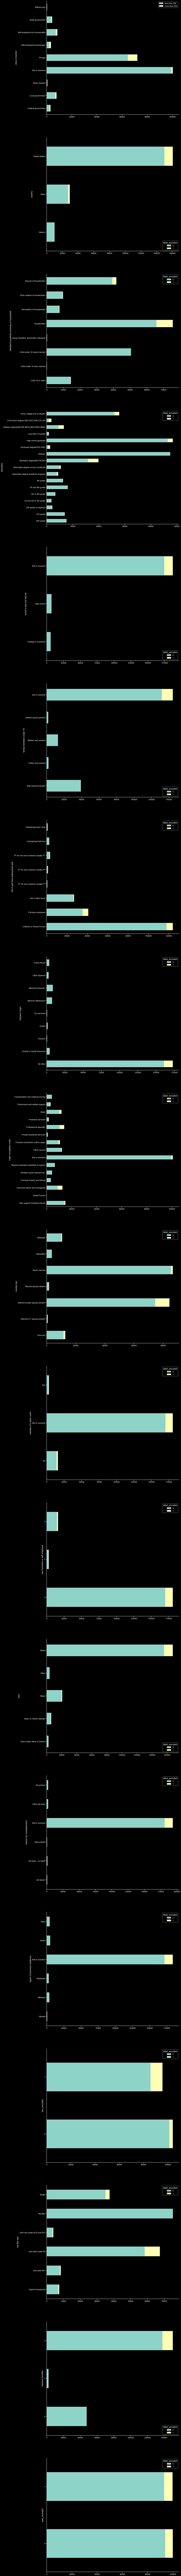

In [82]:
plot_disc(df,var_cont)

In [76]:
len(var_disc)

19